In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [41]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [3]:
anatomy_values = pd.read_csv('/external/rprshnas01/kcni/mabdelhack/uk_biobank/tfmri/imaging/anatomy_hcp180/ct_ordered.csv', header=None)
anatomy_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40699 entries, 0 to 40698
Columns: 360 entries, 0 to 359
dtypes: float64(360)
memory usage: 111.8 MB


In [4]:
with open('/external/rprshnas01/kcni/mabdelhack/uk_biobank/tfmri/imaging/anatomy_hcp180/region_labels.txt', 'r') as f:
    roi_list = f.readline()
roi_list = roi_list.strip().split(';')
roi_list = [x[1:-1] for x in roi_list]

anatomy_values.columns = roi_list
len(roi_list)

360

In [5]:

with open('/external/rprshnas01/kcni/mabdelhack/uk_biobank/tfmri/imaging/freesurfer_label_info/hcp180/roi_names.txt', 'r') as f:
    roi_list = f.readlines()
roi_list = [s.strip() for s in roi_list]
roi_list_model=[]
for roi in roi_list:
    anatomy_values['hcp180_{}'.format(roi)] = anatomy_values[['L_{}'.format(roi), 'R_{}'.format(roi)]].mean(axis=1)
    roi_list_model.append('hcp180_{}'.format(roi))
    

In [6]:
with open('/external/rprshnas01/kcni/mabdelhack/uk_biobank/tfmri/imaging/anatomy_hcp180/subjects_all.txt', 'r') as f:
    subj_list = f.readlines()
subj_list = [int(s.strip()) for s in subj_list]
anatomy_values.index = subj_list

In [7]:
anatomy_values.isna().sum()

L_V1_ROI            1173
L_MST_ROI           1173
L_V6_ROI            1173
L_V2_ROI            1173
L_V3_ROI            1173
                    ... 
hcp180_STSva_ROI    1173
hcp180_TE1m_ROI     1173
hcp180_PI_ROI       1173
hcp180_a32pr_ROI    1173
hcp180_p24_ROI      1173
Length: 540, dtype: int64

In [8]:
n_std = 2
for col in anatomy_values.columns:
    mean = anatomy_values[col].mean()
    sd = anatomy_values[col].std()

    anatomy_values.loc[(anatomy_values[col] > mean+(n_std*sd)), col] = np.nan

In [9]:
anatomy_values.isna().sum()

L_V1_ROI            1926
L_MST_ROI           2166
L_V6_ROI            2179
L_V2_ROI            2138
L_V3_ROI            2025
                    ... 
hcp180_STSva_ROI    1709
hcp180_TE1m_ROI     1906
hcp180_PI_ROI       1810
hcp180_a32pr_ROI    1789
hcp180_p24_ROI      1861
Length: 540, dtype: int64

In [10]:
ukb_tabular = pd.read_csv('/external/rprshnas01/kcni/mabdelhack/ml_tester/data/ukbiobank_sleep_variables_20220526_0910/data.csv', index_col='eid')
ukb_tabular.loc[ukb_tabular['Frequency of depressed mood in last 2 weeks']==0.0, 'Frequency of depressed mood in last 2 weeks'] = np.nan
ukb_tabular.loc[ukb_tabular['Frequency of depressed mood in last 2 weeks']==1.0, 'Frequency of depressed mood in last 2 weeks'] = np.nan
ukb_tabular.loc[ukb_tabular['Frequency of unenthusiasm / disinterest in last 2 weeks']==0.0, 'Frequency of unenthusiasm / disinterest in last 2 weeks'] = np.nan
ukb_tabular.loc[ukb_tabular['Frequency of unenthusiasm / disinterest in last 2 weeks']==1.0, 'Frequency of unenthusiasm / disinterest in last 2 weeks'] = np.nan
ukb_tabular.loc[ukb_tabular['Daytime dozing / sleeping (narcolepsy)']==0.0, 'Daytime dozing / sleeping (narcolepsy)'] = np.nan
ukb_tabular.loc[ukb_tabular['Daytime dozing / sleeping (narcolepsy)']==1.0, 'Daytime dozing / sleeping (narcolepsy)'] = np.nan
ukb_tabular.loc[ukb_tabular['Sleeplessness / insomnia']==0.0, 'Sleeplessness / insomnia'] = np.nan
ukb_tabular.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41169 entries, 1000177 to 6024843
Data columns (total 68 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Year of birth                                                          41169 non-null  float64
 1   Sex                                                                    41169 non-null  object 
 2   Summed MET minutes per week for all activity                           35061 non-null  float64
 3   Mean time to correctly identify matches                                38394 non-null  float64
 4   Maximum digits remembered correctly                                    28237 non-null  float64
 5   Fluid intelligence score                                               37908 non-null  float64
 6   Time to answer                                                         38612 n

In [11]:
tabular_tfmri = pd.merge(ukb_tabular, anatomy_values, how='inner', left_index=True, right_index=True)
tabular_tfmri.shape

(34513, 608)

In [42]:
 tabular_tfmri['duration_of_longest_sleep_bout_7'] = np.abs(tabular_tfmri['duration_of_longest_sleep_bout'] - 7)

In [43]:
tabular_tfmri.columns

Index(['Year of birth', 'Sex', 'Summed MET minutes per week for all activity',
       'Mean time to correctly identify matches',
       'Maximum digits remembered correctly', 'Fluid intelligence score',
       'Time to answer', 'Duration to complete alphanumeric path',
       'Total errors traversing alphanumeric path',
       'Number of puzzles correctly solved',
       ...
       'hcp180_TGv_ROI', 'hcp180_MBelt_ROI', 'hcp180_LBelt_ROI',
       'hcp180_A4_ROI', 'hcp180_STSva_ROI', 'hcp180_TE1m_ROI', 'hcp180_PI_ROI',
       'hcp180_a32pr_ROI', 'hcp180_p24_ROI',
       'duration_of_longest_sleep_bout_7'],
      dtype='object', length=609)

<AxesSubplot:>

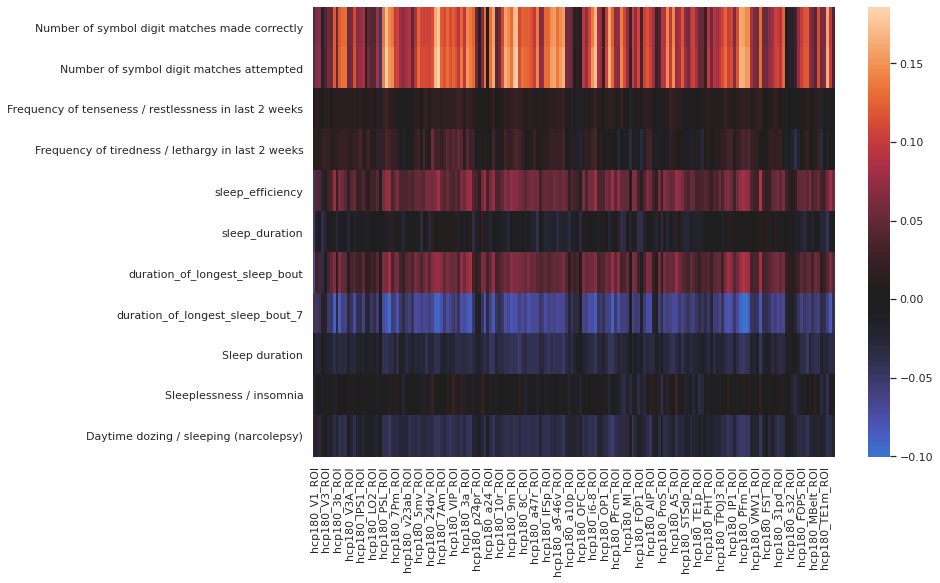

In [44]:
volume_variables = [variable_name for variable_name in tabular_tfmri.columns if variable_name.endswith('_ROI')]
tabular_columns_corr = [
                        'Number of symbol digit matches made correctly',
                        'Number of symbol digit matches attempted',
                        'Frequency of tenseness / restlessness in last 2 weeks',
                        'Frequency of tiredness / lethargy in last 2 weeks',
                        'sleep_efficiency',
                        'sleep_duration',
                        'duration_of_longest_sleep_bout',
                        'duration_of_longest_sleep_bout_7',
                        'Sleep duration',
                        'Sleeplessness / insomnia',
                        'Daytime dozing / sleeping (narcolepsy)']
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(tabular_tfmri.corr().loc[tabular_columns_corr, roi_list_model], center=0 )

In [45]:
sleep_efficiency_df = tabular_tfmri.corr().loc['duration_of_longest_sleep_bout', thickness_variables]
# sleep_efficiency_df.to_csv('test_data.csv')

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['hcp180_p9_46v_ROI', 'hcp180_a9_46v_ROI', 'hcp180_9_46d_ROI',\n       'hcp180_i6_8_ROI', 'hcp180_s6_8_ROI', 'hcp180_OP2_3_ROI'],\n      dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [12]:
from make_roi_based_brain_map import roi_based_to_brain_map, show_roi_order, reorder_to_roi_order, create_animated_roi_brain_map

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection

In [14]:
covariates_anatomy_df = pd.read_csv('covariates_anatomy_230123.csv', index_col='eid')
covariates_anatomy_df['sex'] = covariates_anatomy_df['sex'].astype("category")
covariates_anatomy_df['ethnicity'] = covariates_anatomy_df['ethnicity'].astype("category")
covariates_anatomy_df['site'] = covariates_anatomy_df['site'].astype("category")
covariates_anatomy_df['age'] = (covariates_anatomy_df['age'] - covariates_anatomy_df['age'].mean()) / covariates_anatomy_df['age'].std()
covariates_anatomy_df['ses'] = (covariates_anatomy_df['ses'] - covariates_anatomy_df['ses'].mean()) / covariates_anatomy_df['ses'].std()
covariates_anatomy_df['education'] = (covariates_anatomy_df['education'] - covariates_anatomy_df['education'].mean()) / covariates_anatomy_df['education'].std()
covariates_anatomy_df['actigraphy_time'] = (covariates_anatomy_df['actigraphy_time'] - covariates_anatomy_df['actigraphy_time'].mean()) / covariates_anatomy_df['actigraphy_time'].std()
# covariates_anatomy_df['head_motion'] = (covariates_anatomy_df['head_motion'] - covariates_anatomy_df['head_motion'].mean()) / covariates_anatomy_df['head_motion'].std()
covariates_anatomy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52343 entries, 1000168 to 6024843
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              52343 non-null  float64 
 1   sex              52343 non-null  category
 2   ses              52343 non-null  float64 
 3   education        52343 non-null  float64 
 4   ethnicity        52198 non-null  category
 5   actigraphy_time  22321 non-null  float64 
 6   site             52339 non-null  category
dtypes: category(3), float64(4)
memory usage: 2.1 MB


In [15]:
tabular_tfmri = pd.merge(tabular_tfmri, covariates_anatomy_df, how='inner', left_index=True, right_index=True)
tabular_tfmri.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34513 entries, 1000177 to 6024843
Columns: 615 entries, Year of birth to site
dtypes: category(3), float64(586), int64(10), object(16)
memory usage: 161.5+ MB


In [16]:
tabular_tfmri.columns = tabular_tfmri.columns.str.replace('-', '_')

In [17]:
thickness_variables = [variable_name for variable_name in tabular_tfmri.columns if variable_name.startswith('hcp180_')]

In [ ]:
independent_var = 'duration_of_longest_sleep_bout'
pt_values = pd.DataFrame(index=thickness_variables, columns=['p', 't'])
tvalues = np.zeros((210,))
for thickness_variable in thickness_variables:
#     print('{} ~ {} + C(site) + age + C(sex) + age:C(sex) + actigraphy_time'.format(thickness_variable, independent_var))
#     phenotype_name = 'IC_pair{}'.format(pairwise_connectivity)
    lr_model = smf.ols('{} ~ {} + C(site) + age + C(sex) + age:C(sex) + ses + education + C(ethnicity) + actigraphy_time'.format(thickness_variable, independent_var),
                           data=tabular_tfmri)
    lr_results = lr_model.fit()
    
    pt_values.loc[thickness_variable, 'p'] = lr_results.pvalues[independent_var]
    pt_values.loc[thickness_variable, 't'] = lr_results.tvalues[independent_var]
    pt_values.loc[thickness_variable, 'b'] = lr_results.params[independent_var]
print(pt_values)

In [21]:
pt_values['p_fdr'] = fdrcorrection(pt_values['p'], alpha=0.05, method='i')[1]

In [22]:
pt_values['b_corrected'] = pt_values['b']
pt_values.loc[pt_values['p_fdr'] >=(0.05)/4, 'b_corrected'] = np.nan

In [23]:
lh_bvals = reorder_to_roi_order(pt_values['b_corrected'].to_frame(), 'lh', None, parcellation='hcp180')
rh_bvals = reorder_to_roi_order(pt_values['b_corrected'].to_frame(), 'rh', None, parcellation='hcp180')

In [24]:
lh_bvals

,b_corrected
???,NaN
L_V1_ROI,-0.003676
L_MST_ROI,NaN
L_V6_ROI,NaN
L_V2_ROI,-0.002077
...,...
L_STSva_ROI,NaN
L_TE1m_ROI,NaN
L_PI_ROI,0.004793
L_a32pr_ROI,0.003265


In [29]:
roi_based_to_brain_map([lh_tvals.values, rh_tvals.values], 'anatomy', '{}_b_fdr_hcp180'.format(independent_var), parcellation='hcp180')

In [20]:
def make_ols_maps(data, indep_variable, output_list):
    
    data[indep_variable] = (data[indep_variable] - data[indep_variable].mean() ) / data[indep_variable].std()


    pt_values = dict()

    for idx, roi in enumerate(output_list):
        phenotype_name = roi
        if indep_variable == 'duration_of_longest_sleep_bout':
            lr_model = smf.ols('{} ~ {} + C(site) + age + C(sex) + age:C(sex) + ses + education + C(ethnicity) + actigraphy_time'.format(phenotype_name, indep_variable),
                                   data=data)
        else:
            lr_model = smf.ols('{} ~ {} + C(site) + age + C(sex) + age:C(sex) + ses + education + C(ethnicity)'.format(phenotype_name, indep_variable),
                                   data=data)
        lr_results = lr_model.fit()
    #     print(lr_results.summary())
    #     break
        for idx2 , var in enumerate(lr_results.pvalues.keys()):
            if var not in pt_values.keys():
                pt_values[var] = pd.DataFrame(index=output_list, columns=['p', 't'])
            pt_values[var].loc[roi, 'p'] = lr_results.pvalues[var]
            pt_values[var].loc[roi, 't'] = lr_results.tvalues[var]
            pt_values[var].loc[roi, 'b'] = lr_results.params[var]
    for idx, variable in enumerate(pt_values.keys()):
        pt_values[variable]['p_fdr'] = fdrcorrection(pt_values[variable]['p'], alpha=0.05, method='i')[1]
        pt_values[variable]['t_sig'] = pt_values[variable]['t']
        pt_values[variable]['b_sig'] = pt_values[variable]['b']
        pt_values[variable]['p_bonf'] = pt_values[variable]['p'] * 180 * 4
        pt_values[variable].loc[pt_values[variable]['p_fdr'] >=(0.05)/4, 't_sig'] = np.nan
        pt_values[variable].loc[pt_values[variable]['p_fdr'] >=(0.05)/4, 'b_sig'] = np.nan
        pt_values[variable]['t_bonf'] = pt_values[variable]['t']
        pt_values[variable]['b_bonf'] = pt_values[variable]['b']
        pt_values[variable].loc[pt_values[variable]['p_bonf'] >=(0.05), 't_bonf'] = np.nan
        pt_values[variable].loc[pt_values[variable]['p_bonf'] >=(0.05), 'b_bonf'] = np.nan
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['t'].to_frame(), 'lh', None, parcellation='hcp180')
        roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'anatomy', '{}_{}_hcp180_t'.format(indep_variable, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_sig'].to_frame(), 'lh', None, parcellation='hcp180')
        roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'anatomy', '{}_{}_hcp180_t_sig'.format(indep_variable, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['t_bonf'].to_frame(), 'lh', None, parcellation='hcp180')
        roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'anatomy', '{}_{}_hcp180_t_bonf'.format(indep_variable, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['b'].to_frame(), 'lh', None, parcellation='hcp180')
        roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'anatomy', '{}_{}_hcp180_b'.format(indep_variable, variable), parcellation='hcp180')

        lh_correlations = reorder_to_roi_order(pt_values[variable]['b_sig'].to_frame(), 'lh', None, parcellation='hcp180')
        roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'anatomy', '{}_{}_hcp180_b_sig'.format(indep_variable, variable), parcellation='hcp180')
        
        lh_correlations = reorder_to_roi_order(pt_values[variable]['b_bonf'].to_frame(), 'lh', None, parcellation='hcp180')
        roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'anatomy', '{}_{}_hcp180_b_bonf'.format(indep_variable, variable), parcellation='hcp180')

    
    return pt_values

In [25]:
def make_ols_maps_sex(data, indep_variable, output_list):
    
    data[independent_var] = (data[indep_variable] - data[indep_variable].mean() ) / data[indep_variable].std()


    pt_values_strat = dict()
    for sex in ['Male', 'Female']:
        pt_values = dict()
        data_strat = data.loc[data['sex'] == sex]

        for idx, roi in enumerate(output_list):
            phenotype_name = roi

            lr_model = smf.ols('{} ~ {} + C(site) + age + actigraphy_time'.format(phenotype_name, indep_variable),
                                   data=data_strat)
            lr_results = lr_model.fit()
        #     print(lr_results.summary())
        #     break
            for idx2 , var in enumerate(lr_results.pvalues.keys()):
                if var not in pt_values.keys():
                    pt_values[var] = pd.DataFrame(index=output_list, columns=['p', 't'])
                pt_values[var].loc[roi, 'p'] = lr_results.pvalues[var]
                pt_values[var].loc[roi, 't'] = lr_results.tvalues[var]
        for idx, variable in enumerate(pt_values.keys()):
            pt_values[variable]['p_fdr'] = fdrcorrection(pt_values[variable]['p'], alpha=0.05, method='i')[1]
            pt_values[variable]['t_sig'] = pt_values[variable]['t']
            pt_values[variable]['p_bonf'] = pt_values[variable]['p'] * 180 * 4
            pt_values[variable].loc[pt_values[variable]['p_fdr'] >=(0.05)/4, 't_sig'] = np.nan
            pt_values[variable]['t_bonf'] = pt_values[variable]['t']
            pt_values[variable].loc[pt_values[variable]['p_bonf'] >=(0.05), 't_bonf'] = np.nan

            lh_correlations = reorder_to_roi_order(pt_values[variable]['t'].to_frame(), 'lh', None, parcellation='hcp180')
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'anatomy', '{}_{}_hcp180_t_{}'.format(indep_variable, variable, sex), parcellation='hcp180')

            lh_correlations = reorder_to_roi_order(pt_values[variable]['t_sig'].to_frame(), 'lh', None, parcellation='hcp180')
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'anatomy', '{}_{}_hcp180_t_sig_{}'.format(indep_variable, variable, sex), parcellation='hcp180')\

            lh_correlations = reorder_to_roi_order(pt_values[variable]['t_bonf'].to_frame(), 'lh', None, parcellation='hcp180')
            roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'anatomy', '{}_{}_hcp180_t_bonf_{}'.format(indep_variable, variable, sex), parcellation='hcp180')
    pt_values_strat[sex] = pt_values
    
    return pt_values_strat

In [53]:
independent_var = 'duration_of_longest_sleep_bout'
make_ols_maps(tabular_tfmri, independent_var, thickness_variables)
# make_ols_maps_sex(tabular_tfmri, independent_var, thickness_variables)

{'Intercept':                           p         t             b     p_fdr t_sig  b_sig  \
 hcp180_V1_ROI      0.790208 -0.266045 -8.868274e+09  0.998499   NaN    NaN   
 hcp180_MST_ROI     0.524614 -0.636266 -1.996067e+10  0.998499   NaN    NaN   
 hcp180_V6_ROI     0.0483567   -1.9744 -1.085893e+11  0.998499   NaN    NaN   
 hcp180_V2_ROI      0.823357 -0.223233 -6.645269e+09  0.998499   NaN    NaN   
 hcp180_V3_ROI       0.32486 -0.984556 -6.709676e+10  0.998499   NaN    NaN   
 ...                     ...       ...           ...       ...   ...    ...   
 hcp180_STSva_ROI   0.710888  0.370671  2.845201e+10  0.998499   NaN    NaN   
 hcp180_TE1m_ROI     0.47226 -0.718827 -1.919915e+10  0.998499   NaN    NaN   
 hcp180_PI_ROI      0.863388  0.172066  1.558342e+10  0.998499   NaN    NaN   
 hcp180_a32pr_ROI    0.15125   1.43521  3.047063e+10  0.998499   NaN    NaN   
 hcp180_p24_ROI     0.543472  0.607587  2.262733e+10  0.998499   NaN    NaN   
 
                    p_bonf t_bonf  b_

In [18]:
tabular_tfmri.columns = tabular_tfmri.columns.str.replace('.', '_')
tabular_tfmri.columns = tabular_tfmri.columns.str.replace(' ', '_')
tabular_tfmri.columns = tabular_tfmri.columns.str.replace('/', '_')
tabular_tfmri.columns = tabular_tfmri.columns.str.replace('(', '')
tabular_tfmri.columns = tabular_tfmri.columns.str.replace(')', '')

In [55]:
independent_var = 'Number_of_symbol_digit_matches_made_correctly'
make_ols_maps(tabular_tfmri, independent_var, thickness_variables)
# make_ols_maps_sex(tabular_tfmri, independent_var, thickness_variables)

{'Intercept':                           p          t             b     p_fdr t_sig  b_sig  \
 hcp180_V1_ROI      0.853584   -0.18455 -1.590002e+09  0.972437   NaN    NaN   
 hcp180_MST_ROI     0.884272   0.145558  1.827253e+09  0.984526   NaN    NaN   
 hcp180_V6_ROI     0.0914362    1.68795  2.990401e+10  0.946963   NaN    NaN   
 hcp180_V2_ROI      0.711023  -0.370487 -8.517163e+09  0.950157   NaN    NaN   
 hcp180_V3_ROI       0.20149    1.27736  1.885767e+10  0.946963   NaN    NaN   
 ...                     ...        ...           ...       ...   ...    ...   
 hcp180_STSva_ROI   0.124964   -1.53433 -3.825081e+10  0.946963   NaN    NaN   
 hcp180_TE1m_ROI    0.965709  0.0429906  9.196185e+08  0.999992   NaN    NaN   
 hcp180_PI_ROI      0.588511   0.541004  1.684653e+10  0.949051   NaN    NaN   
 hcp180_a32pr_ROI  0.0177551    2.37088  5.347657e+10  0.946963   NaN    NaN   
 hcp180_p24_ROI     0.300387    1.03563  2.262261e+10  0.946963   NaN    NaN   
 
                    p_bon

In [56]:
independent_var = 'Sleeplessness___insomnia'
make_ols_maps(tabular_tfmri, independent_var, thickness_variables)
# make_ols_maps_sex(tabular_tfmri, independent_var, thickness_variables)

{'Intercept':                           p         t             b     p_fdr t_sig  b_sig  \
 hcp180_V1_ROI      0.729093 -0.346335 -2.167300e+09  0.998935   NaN    NaN   
 hcp180_MST_ROI     0.332968 -0.968168 -7.158048e+09  0.998935   NaN    NaN   
 hcp180_V6_ROI     0.0531545   1.93373  2.255959e+10  0.998935   NaN    NaN   
 hcp180_V2_ROI       0.25348  -1.14196 -4.995478e+09  0.998935   NaN    NaN   
 hcp180_V3_ROI      0.223439   1.21746  6.817231e+09  0.998935   NaN    NaN   
 ...                     ...       ...           ...       ...   ...    ...   
 hcp180_STSva_ROI   0.530545 -0.627181 -5.282839e+09  0.998935   NaN    NaN   
 hcp180_TE1m_ROI    0.141646   1.46972  1.884940e+10  0.998935   NaN    NaN   
 hcp180_PI_ROI      0.874519 -0.157922 -1.887114e+09  0.998935   NaN    NaN   
 hcp180_a32pr_ROI   0.018018   2.36537  2.059871e+10  0.998935   NaN    NaN   
 hcp180_p24_ROI      0.56888 -0.569708 -9.262347e+09  0.998935   NaN    NaN   
 
                    p_bonf t_bonf  b_

In [19]:
tabular_tfmri['phq2'] = tabular_tfmri['Frequency_of_depressed_mood_in_last_2_weeks'] + tabular_tfmri['Frequency_of_unenthusiasm___disinterest_in_last_2_weeks']

In [58]:
independent_var = 'phq2'
make_ols_maps(tabular_tfmri, independent_var, thickness_variables)
# make_ols_maps_sex(tabular_tfmri, independent_var, thickness_variables)

{'Intercept':                           p         t             b     p_fdr t_sig  b_sig  \
 hcp180_V1_ROI       0.52401  0.637183  3.375150e+09  0.987572   NaN    NaN   
 hcp180_MST_ROI     0.743349  0.327425  2.114173e+09  0.987572   NaN    NaN   
 hcp180_V6_ROI      0.917619  0.103435  1.263892e+09  0.987572   NaN    NaN   
 hcp180_V2_ROI      0.905098 -0.119224 -5.062082e+08  0.987572   NaN    NaN   
 hcp180_V3_ROI       0.47802 -0.709499 -3.879843e+09  0.987572   NaN    NaN   
 ...                     ...       ...           ...       ...   ...    ...   
 hcp180_STSva_ROI   0.741455  0.329931  3.974726e+09  0.987572   NaN    NaN   
 hcp180_TE1m_ROI    0.121073  -1.55033 -1.440119e+10  0.987572   NaN    NaN   
 hcp180_PI_ROI      0.201008   1.27871  4.527854e+10  0.987572   NaN    NaN   
 hcp180_a32pr_ROI  0.0207336  -2.31292 -2.024111e+10  0.987572   NaN    NaN   
 hcp180_p24_ROI     0.394437  0.851611  1.330112e+10  0.987572   NaN    NaN   
 
                    p_bonf t_bonf  b_

In [59]:
independent_var = 'Daytime_dozing___sleeping_narcolepsy'
make_ols_maps(tabular_tfmri, independent_var, thickness_variables)

{'Intercept':                          p         t             b     p_fdr t_sig  b_sig  \
 hcp180_V1_ROI     0.823924 -0.222502 -1.095852e+09  0.987877   NaN    NaN   
 hcp180_MST_ROI    0.144165  -1.46049 -9.259746e+09  0.987877   NaN    NaN   
 hcp180_V6_ROI     0.728467 -0.347169 -2.300039e+09  0.987877   NaN    NaN   
 hcp180_V2_ROI     0.516113  0.649355  3.708957e+09  0.987877   NaN    NaN   
 hcp180_V3_ROI     0.310201   1.01482  5.674166e+09  0.987877   NaN    NaN   
 ...                    ...       ...           ...       ...   ...    ...   
 hcp180_STSva_ROI  0.690096 -0.398728 -3.927801e+09  0.987877   NaN    NaN   
 hcp180_TE1m_ROI   0.102538  -1.63272 -1.479436e+10  0.987877   NaN    NaN   
 hcp180_PI_ROI     0.180889   1.33805  3.096154e+10  0.987877   NaN    NaN   
 hcp180_a32pr_ROI  0.705046  0.378521  3.874152e+09  0.987877   NaN    NaN   
 hcp180_p24_ROI    0.223307  -1.21781 -1.785376e+10  0.987877   NaN    NaN   
 
                    p_bonf t_bonf  b_bonf  
 hcp1

In [22]:
t_fdr_independent = pd.DataFrame()
t_independent = pd.DataFrame()
for independent_var in ['Sleep_duration', 'duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2', 'Daytime_dozing___sleeping_narcolepsy']:
    data_stats = make_ols_maps(tabular_tfmri, independent_var, thickness_variables)
    t_fdr_independent[independent_var] = data_stats[independent_var]['b_sig']
    t_independent[independent_var] = data_stats[independent_var]['b']

In [61]:
for x in t_independent.index:
    print(x)

hcp180_V1_ROI
hcp180_MST_ROI
hcp180_V6_ROI
hcp180_V2_ROI
hcp180_V3_ROI
hcp180_V4_ROI
hcp180_V8_ROI
hcp180_4_ROI
hcp180_3b_ROI
hcp180_FEF_ROI
hcp180_PEF_ROI
hcp180_55b_ROI
hcp180_V3A_ROI
hcp180_RSC_ROI
hcp180_POS2_ROI
hcp180_V7_ROI
hcp180_IPS1_ROI
hcp180_FFC_ROI
hcp180_V3B_ROI
hcp180_LO1_ROI
hcp180_LO2_ROI
hcp180_PIT_ROI
hcp180_MT_ROI
hcp180_A1_ROI
hcp180_PSL_ROI
hcp180_SFL_ROI
hcp180_PCV_ROI
hcp180_STV_ROI
hcp180_7Pm_ROI
hcp180_7m_ROI
hcp180_POS1_ROI
hcp180_23d_ROI
hcp180_v23ab_ROI
hcp180_d23ab_ROI
hcp180_31pv_ROI
hcp180_5m_ROI
hcp180_5mv_ROI
hcp180_23c_ROI
hcp180_5L_ROI
hcp180_24dd_ROI
hcp180_24dv_ROI
hcp180_7AL_ROI
hcp180_SCEF_ROI
hcp180_6ma_ROI
hcp180_7Am_ROI
hcp180_7PL_ROI
hcp180_7PC_ROI
hcp180_LIPv_ROI
hcp180_VIP_ROI
hcp180_MIP_ROI
hcp180_1_ROI
hcp180_2_ROI
hcp180_3a_ROI
hcp180_6d_ROI
hcp180_6mp_ROI
hcp180_6v_ROI
hcp180_p24pr_ROI
hcp180_33pr_ROI
hcp180_a24pr_ROI
hcp180_p32pr_ROI
hcp180_a24_ROI
hcp180_d32_ROI
hcp180_8BM_ROI
hcp180_p32_ROI
hcp180_10r_ROI
hcp180_47m_ROI
hcp180_8Av_RO

In [72]:
t_fdr_independent_sig = t_fdr_independent[(~t_fdr_independent.isna()).sum(axis=1) > 1]
t_fdr_independent_sig
# t_fdr_independent_sig.sort_values(by='Number_of_symbol_digit_matches_made_correctly', ascending=False)

,duration_of_longest_sleep_bout,Sleeplessness___insomnia,Number_of_symbol_digit_matches_made_correctly,phq2,Daytime_dozing___sleeping_narcolepsy
hcp180_V1_ROI,-0.005842,NaN,-0.004864,0.002939,NaN
hcp180_V2_ROI,-0.003329,NaN,-0.004067,0.002051,NaN
hcp180_4_ROI,0.006172,NaN,NaN,-0.005067,NaN
hcp180_6ma_ROI,0.005514,NaN,0.006749,NaN,NaN
hcp180_7Am_ROI,0.005922,NaN,NaN,-0.003304,NaN
hcp180_6mp_ROI,0.007499,NaN,NaN,-0.004392,NaN
hcp180_d32_ROI,NaN,NaN,0.004791,-0.003566,NaN
hcp180_44_ROI,NaN,NaN,0.004390,-0.003830,NaN
hcp180_6r_ROI,NaN,NaN,0.003741,-0.003626,NaN
hcp180_13l_ROI,NaN,NaN,NaN,-0.003929,-0.003553


In [33]:
beta_overlap = (~t_fdr_independent.isna()).astype(int).astype(str).agg(''.join, axis=1).astype(int)
print(beta_overlap.index)
lh_correlations = reorder_to_roi_order(beta_overlap.to_frame(), 'lh', None, parcellation='hcp180')
roi_based_to_brain_map([lh_correlations.values, lh_correlations.values],'anatomy', 'sig_overlap_pattern', parcellation='hcp180')

Index(['hcp180_V1_ROI', 'hcp180_MST_ROI', 'hcp180_V6_ROI', 'hcp180_V2_ROI',
       'hcp180_V3_ROI', 'hcp180_V4_ROI', 'hcp180_V8_ROI', 'hcp180_4_ROI',
       'hcp180_3b_ROI', 'hcp180_FEF_ROI',
       ...
       'hcp180_p47r_ROI', 'hcp180_TGv_ROI', 'hcp180_MBelt_ROI',
       'hcp180_LBelt_ROI', 'hcp180_A4_ROI', 'hcp180_STSva_ROI',
       'hcp180_TE1m_ROI', 'hcp180_PI_ROI', 'hcp180_a32pr_ROI',
       'hcp180_p24_ROI'],
      dtype='object', length=180)


In [34]:
beta_overlap.value_counts().sort_index()

0        105
1          3
10        13
11         3
100       14
110        7
10000     16
10001      1
10010      9
10100      2
10101      1
10110      6
dtype: int64

In [26]:
create_animated_roi_brain_map(reordered_rh, hemisphere='right', parcellation='dsk', title='', cblabel='t_value', save=True)

Creation of a scene
BrainObj(name='inflated') created
/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/vispy/gloo/buffer.py:454: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = data.view(dtype=[('f0', data.dtype.base, c)])
    Annot file loaded (/external/rprshnas01/kcni/mabdelhack/uk_biobank/tfmri/imaging/fsaverage/label/rh.aparc.annot)
    Color inferred from data
    Search parcellates using labels
    Selected parcellates : caudalanteriorcingulate, caudalmiddlefrontal, fusiform, inferiorparietal, inferiortemporal, lateralorbitofrontal, parsopercularis, pericalcarine, precuneus, superiorfrontal, superiortemporal, supramarginal, insula
    BrainObj(name='inflated') added to the scene
Get colorbar properties from BrainObj(name='inflated') object
ColorbarObj(name='inflatedCbar') created
    ColorbarObj(name='inflatedCbar') added to the scene


In [36]:
pt_values.loc[pt_values['p_fdr'] < 0.05]

,p,t,p_fdr
L_V1_ROI,9.19262e-06,-4.43697,0.000472763
L_V4_ROI,0.00978544,2.58367,0.0366954
L_4_ROI,0.000409164,3.53495,0.00460309
L_FEF_ROI,0.00079784,3.35427,0.0079784
L_PEF_ROI,0.00213422,3.07146,0.0167026
...,...,...,...
R_pOFC_ROI,7.29805e-05,3.96754,0.00156456
R_PoI1_ROI,0.0106462,2.55444,0.0383264
R_FOP5_ROI,0.00919269,2.60516,0.0348354
R_TGv_ROI,4.37342e-05,4.0881,0.0012111


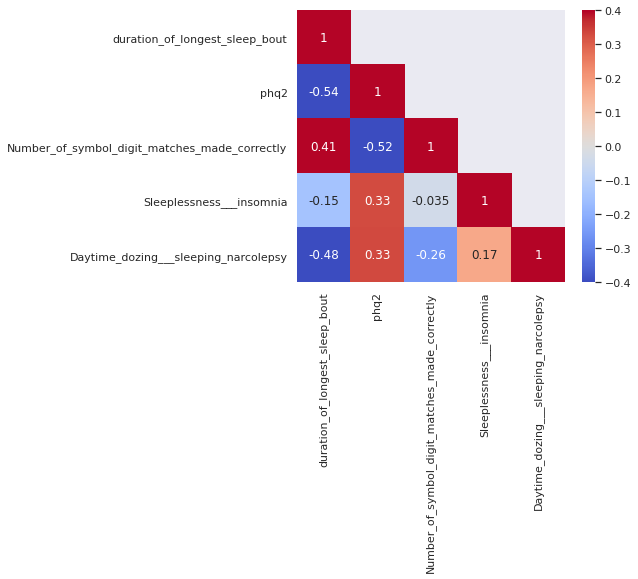

In [62]:
fig, ax = plt.subplots(1,1, figsize=(6, 5))
correlation_values = t_independent[['duration_of_longest_sleep_bout', 'phq2', 'Number_of_symbol_digit_matches_made_correctly', 'Sleeplessness___insomnia', 'Daytime_dozing___sleeping_narcolepsy']].corr()
correlation_values.values[np.triu_indices(5,1)] = np.nan
sns.heatmap(correlation_values, 
            annot=True, cmap='coolwarm', center=0.0, vmin=-.4, vmax=.4)
fig.savefig('corr_plot_anatomymri_ct_230402.pdf')

In [23]:
variables = ['Sleep_duration', 'duration_of_longest_sleep_bout', 'phq2', 'Number_of_symbol_digit_matches_made_correctly', 'Sleeplessness___insomnia', 'Daytime_dozing___sleeping_narcolepsy']
for var1 in variables:
    for var2 in variables:
        corrvals = pearsonr_ci(t_independent[var1], 
                               t_independent[var2], alpha=0.05/5)
        print(var1, var2, corrvals)

Sleep_duration Sleep_duration (0.9999999999999999, 0.0, 0.9999999999999999, 0.9999999999999999)
Sleep_duration duration_of_longest_sleep_bout (-0.02216711523611326, 0.7677132100499601, -0.21249408718597443, 0.16978030527484395)
Sleep_duration phq2 (0.26618520968722303, 0.00030413537260492746, 0.0789775994932243, 0.435257464774951)
Sleep_duration Number_of_symbol_digit_matches_made_correctly (-0.19447242067304052, 0.008897487231594491, -0.3718708228819182, -0.003370019312553712)
Sleep_duration Sleeplessness___insomnia (-0.1406989215962859, 0.05957775919180584, -0.3232299736088144, 0.05192589991021129)
Sleep_duration Daytime_dozing___sleeping_narcolepsy (-0.033347239585948825, 0.6567484350381115, -0.22315194557406054, 0.15889373996820652)
duration_of_longest_sleep_bout Sleep_duration (-0.02216711523611326, 0.7677132100499601, -0.21249408718597443, 0.16978030527484395)
duration_of_longest_sleep_bout duration_of_longest_sleep_bout (1.0, 0.0, 1.0, 1.0)
duration_of_longest_sleep_bout phq2 (-

/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in arctanh


In [64]:
from nibabel.freesurfer.io import read_annot
_, ctab, roi_names_ctab = read_annot('/external/rprshnas01/kcni/mabdelhack/uk_biobank/tfmri/imaging/fsaverage/label/lh.HCP-MMP1.annot')
ctab = ctab[1:, :3]
print(ctab)
roi_names_ctab = [str(x[2:])[2:-1].replace('-', '_') for x in roi_names_ctab[1:]]
print(roi_names_ctab)
ctab_df = pd.DataFrame(data=ctab.byteswap().newbyteorder(), columns=['r', 'g', 'b'], index=roi_names_ctab)
ctab_df = ctab_df/255.
ctab_df.loc[['V1_ROI', 'V2_ROI']]

[[ 63   5 255]
 [ 54 103 129]
 [ 62  78 178]
 [ 23  50 233]
 [ 15  40 226]
 [ 14  28 214]
 [ 26  47 201]
 [ 33 178  20]
 [ 35 205  21]
 [134 143 137]
 [141 166 152]
 [ 62  88  47]
 [  7  57 246]
 [153  64 133]
 [186  86 188]
 [ 18  70 195]
 [ 57 114 160]
 [ 57  89 117]
 [ 25  47 206]
 [  0  49 184]
 [ 18  33 181]
 [ 34  43 171]
 [ 31  86 104]
 [235  19  47]
 [122  79  56]
 [ 31  49  22]
 [138 128 153]
 [142  87  76]
 [149 181 188]
 [ 42  31  44]
 [ 81  54  98]
 [127  56  91]
 [ 29   0  14]
 [ 63  17  47]
 [ 54  11  42]
 [ 48 163  48]
 [153 172 136]
 [205 190 194]
 [ 64 154  64]
 [ 69 161  44]
 [119 159  66]
 [115 194 134]
 [110 146  86]
 [144 179 135]
 [184 243 224]
 [169 246 237]
 [ 68 177 108]
 [ 63 113 158]
 [ 50 129 137]
 [136 206 204]
 [ 20 191  38]
 [ 48 176  62]
 [ 47 216  22]
 [ 26 158  32]
 [ 64 159  38]
 [ 71 168  50]
 [146 136 107]
 [129 106 103]
 [176 133 130]
 [163 142 121]
 [ 67  12  25]
 [ 90  41  50]
 [105  83  81]
 [ 95  32  52]
 [ 25  12   1]
 [ 96  75  66]
 [ 53  54 

,r,g,b
V1_ROI,0.247059,0.019608,1.000000
V2_ROI,0.090196,0.196078,0.913725


In [65]:
import re
def reorder_to_custom_order(input_data, target_roi_names):
    roi_names_input = input_data.index
    reordered_data = pd.DataFrame(index=list(target_roi_names.values))
    for idx_target, roi_target in enumerate(target_roi_names.values):
        for idx_source, roi_source in enumerate(roi_names_input):
            input_to_regex = roi_target
            input_to_regex = input_to_regex.replace('?', '\?')
            input_to_regex = input_to_regex.replace('-', '_')

            matching_pattern = re.findall('(^|_| |\n){}(_| |\n|$)'.format(input_to_regex), roi_source)
            if len(matching_pattern) > 0:
                reordered_data.loc[roi_target, input_data.columns] = input_data.loc[roi_source]
    # reordered_data.fillna(-99.0, inplace=True)
    return reordered_data

In [66]:
roi_region_pd = pd.read_csv('/external/rprshnas01/kcni/mabdelhack/uk_biobank/tfmri/imaging/anatomy_hcp180/roi_list_hcp180.csv', usecols=['roi_id','roi','primary_section'])
roi_region_pd = roi_region_pd.sort_values(by='primary_section')
roi_region_pd['roi'] = roi_region_pd['roi'].str.replace('-', '_')
ctab_df = reorder_to_custom_order(ctab_df, roi_region_pd['roi'])
ctab_df.values

roi_region_pd

,roi_id,roi,primary_section
0,1,V1,1
3,4,V2,2
4,5,V3,2
5,6,V4,2
2,3,V6,3
...,...,...,...
84,85,a9_46v,22
85,86,9_46d,22
86,87,9a,22
66,67,8Av,22


In [67]:
t_independent = reorder_to_custom_order(t_independent, roi_region_pd['roi'])
t_independent['index'] = np.arange(180)
# t_independent = reorder_to_roi_order(t_independent, 'lh', None, parcellation='hcp180').iloc[1:, :]
t_independent.index.name = 'roi'
t_independent_roi = t_independent.reset_index()
t_independent_roi
t_independent_roi_long = pd.melt(t_independent_roi, value_vars=['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2', 'Daytime_dozing___sleeping_narcolepsy'],
                            var_name='phenotype', id_vars=['roi', 'index'])
t_fdr_independent = reorder_to_custom_order(t_fdr_independent, roi_region_pd['roi'])
t_fdr_independent_long = pd.melt(t_fdr_independent, value_vars=['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2', 'Daytime_dozing___sleeping_narcolepsy'],
                            var_name='phenotype')
# # t_fdr_independent_long
t_independent_roi_long['sig'] = ~t_fdr_independent_long['value'].isna()
t_independent_roi_long

,roi,index,phenotype,value,sig
0,V1,0,duration_of_longest_sleep_bout,-0.005853,True
1,V2,1,duration_of_longest_sleep_bout,-0.003404,True
2,V3,2,duration_of_longest_sleep_bout,-0.001409,False
3,V4,3,duration_of_longest_sleep_bout,0.001387,False
4,V6,4,duration_of_longest_sleep_bout,0.000664,False
...,...,...,...,...,...
895,a9_46v,175,Daytime_dozing___sleeping_narcolepsy,-0.000855,False
896,9_46d,176,Daytime_dozing___sleeping_narcolepsy,-0.000162,False
897,9a,177,Daytime_dozing___sleeping_narcolepsy,-0.001058,False
898,8Av,178,Daytime_dozing___sleeping_narcolepsy,-0.000189,False


In [68]:

ctab_df['primary_section'] = roi_region_pd.set_index('roi')['primary_section']
# ctab_df[['mean_r', 'mean_g', 'mean_b']] = ctab_df.groupby('primary_section').mean()
ctab_df['mean_r'] = ctab_df['primary_section'].map(ctab_df.groupby('primary_section')['r'].apply(lambda x: x.mean()))
ctab_df['mean_g'] = ctab_df['primary_section'].map(ctab_df.groupby('primary_section')['g'].apply(lambda x: x.mean()))
ctab_df['mean_b'] = ctab_df['primary_section'].map(ctab_df.groupby('primary_section')['b'].apply(lambda x: x.mean()))

ctab_df

,r,g,b,primary_section,mean_r,mean_g,mean_b
V1,0.247059,0.019608,1.000000,1,0.247059,0.019608,1.000000
V2,0.090196,0.196078,0.913725,2,0.067974,0.154248,0.879739
V3,0.058824,0.156863,0.886275,2,0.067974,0.154248,0.879739
V4,0.054902,0.109804,0.839216,2,0.067974,0.154248,0.879739
V6,0.243137,0.305882,0.698039,3,0.137255,0.297386,0.752288
...,...,...,...,...,...,...,...
a9_46v,0.568627,0.439216,0.501961,22,0.356863,0.354148,0.313424
9_46d,0.549020,0.458824,0.513725,22,0.356863,0.354148,0.313424
9a,0.215686,0.203922,0.176471,22,0.356863,0.354148,0.313424
8Av,0.207843,0.211765,0.168627,22,0.356863,0.354148,0.313424


/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(-1.0, 1.0)

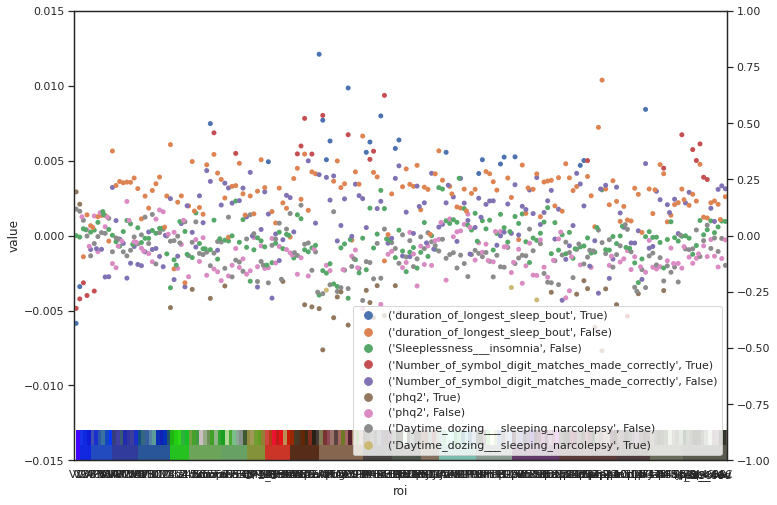

In [69]:
from matplotlib.colors import ListedColormap
sns.set_style(style='white')
fig, ax = plt.subplots(1,1)

sns.swarmplot(data=t_independent_roi_long, x='roi', y='value', hue=t_independent_roi_long[['phenotype', 'sig']].apply(tuple, axis=1), ax=ax, dodge=False)
ax2 = ax.twinx()
# sns.pointplot(data=t_independent_roi_long, x='roi', y='accuracy', ax=ax2, markers='_', dodge=False, ci=None, color='k')
ax.imshow(np.expand_dims(t_independent_roi_long['index'].unique(), axis=0), zorder=0, aspect="auto", extent=(0,180,-0.014,-0.013), 
          cmap=ListedColormap(ctab_df[['r', 'g', 'b']].values))
ax.imshow(np.expand_dims(t_independent_roi_long['index'].unique(), axis=0), zorder=0, aspect="auto", extent=(0,180,-0.015,-0.014), 
          cmap=ListedColormap(ctab_df[['mean_r', 'mean_g', 'mean_b']].values))
ax.set_ylim(-0.015, 0.015)
ax2.set_ylim(-1, 1)
# fig.savefig('overlap_swarmp_plot_phenotype.pdf')
# with sns.plotting_context(rc={"markerfacecolor": None}):
#     sns.swarmplot(data=t_independent, marker="$\circ$", ax=ax)
# t_fdr_independent.T.plot(style='.', marker='o', legend=None, ax=ax)

# plt.legend()

In [70]:
fig.savefig('anatomy_manhattan_plot.pdf')

In [61]:
from sklearn import manifold
from datetime import datetime
start = datetime.now()
mds = manifold.MDS(
    metric=False,
    n_components=2,
    max_iter=50000,
    eps=1e-9,
    random_state=42,
    dissimilarity="euclidean",
    n_jobs=2,
)
t_independent_mds = t_independent[['duration_of_longest_sleep_bout', 'Sleeplessness___insomnia', 'Number_of_symbol_digit_matches_made_correctly', 'phq2']].copy(deep=True)
# t_independent_mds = t_independent_mds.abs()

npos_brain = mds.fit_transform(t_independent_mds.values.T)
npos_brain /= np.sqrt((npos_brain ** 2).sum())
print('Time = {}'.format(datetime.now()-start))

Time = 0:00:05.268383


In [62]:
npos_brain

array([[ 0.07576278,  0.60341245],
       [-0.32972332, -0.13720361],
       [ 0.5100481 , -0.0484018 ],
       [-0.25606488, -0.41779193]])

(-1.0, 1.0)

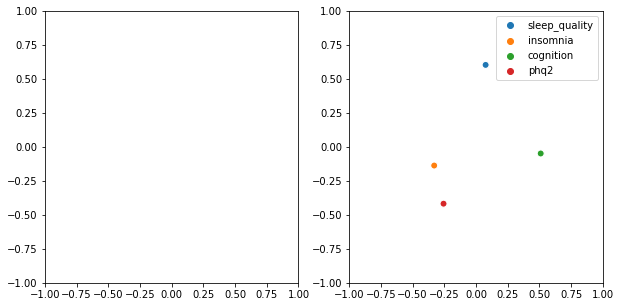

In [63]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
# sns.scatterplot(x=npos_behav[:,0], y=npos_behav[:,1], hue=['sleep_quality', 'insomnia', 'cognition', 'phq2'], marker='+', s=200, ax=axs[0])
sns.scatterplot(x=npos_brain[:,0], y=npos_brain[:,1], hue=['sleep_quality', 'insomnia', 'cognition', 'phq2'], marker='.', s=200, ax=axs[1])
# sns.scatterplot(x=npos_brain_fdr[:,0], y=npos_brain_fdr[:,1], hue=['sleep_quality', 'insomnia', 'cognition', 'phq2'], marker='.', s=200, ax=axs[2])

axs[0].set_xlim(-1,1)

axs[0].set_ylim(-1,1)
axs[1].set_xlim(-1,1)
axs[1].set_ylim(-1,1)
# axs[2].set_xlim(-1,1)
# axs[2].set_ylim(-1,1)
# plt.legend(['sleep_quality', 'insomnia', 'cognition', 'phq2'])

Creation of a scene
BrainObj(name='inflated') created
/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/vispy/gloo/buffer.py:454: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = data.view(dtype=[('f0', data.dtype.base, c)])
    Annot file loaded (/external/rprshnas01/kcni/mabdelhack/uk_biobank/tfmri/imaging/fsaverage/label/rh.aparc.annot)
    Color inferred from data
    Search parcellates using labels
    Selected parcellates : caudalanteriorcingulate, caudalmiddlefrontal, fusiform, inferiorparietal, inferiortemporal, lateralorbitofrontal, parsopercularis, pericalcarine, precuneus, superiorfrontal, superiortemporal, supramarginal, insula
    BrainObj(name='inflated') added to the scene
Get colorbar properties from BrainObj(name='inflated') object
ColorbarObj(name='inflatedCbar') created
    ColorbarObj(name='inflatedCbar') added to the scene
W

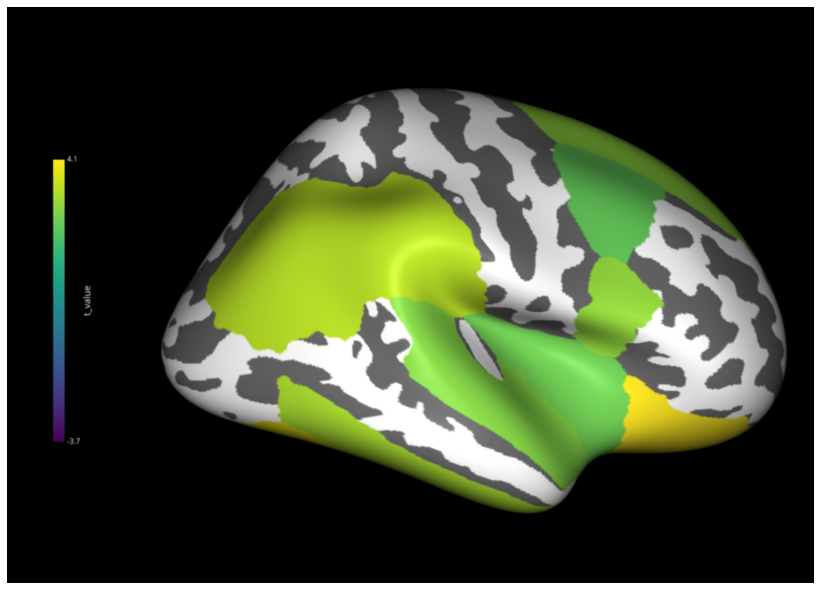

In [28]:
create_animated_roi_brain_map(reordered_rh, hemisphere='right', parcellation='dsk', title='', cblabel='t_value', save=False)

In [24]:
pvals_all.loc[pvals_all['Sleep_duration'] < 0.01]

NameError: name 'pvals_all' is not defined

In [26]:
slp_stats = make_ols_maps(tabular_tfmri, 'Sleep_duration', thickness_variables)

In [30]:
(slp_stats['Sleep_duration']['p'] < 0.01).sum()

55

In [32]:
bvals_all

NameError: name 'bvals_all' is not defined

In [38]:
t_fdr_independent['duration_of_longest_sleep_bout'].max()

0.012104088196150414

In [ ]:
roi_list_presentable = [x.split('_', 2)[2][:-4].replace('_', '-') for x in data_stats['Daytime_dozing___sleeping_narcolepsy'].index]
roi_list_presentable

In [65]:
variables_presentable = ['Duration of longest sleep bout', 'PHQ-2', 'Cognition', 'Self-report insomnia', 'Self-report daytime dozing']
assoc_stats_df = pd.DataFrame(columns=['Variable', 'Region', 'Coefficient', 't-value', 'p-value (raw)', 'p-value (FDR)', 'Significant'],
                                 index=np.arange(180 * 5))
for idx, var in enumerate(['duration_of_longest_sleep_bout', 'phq2', 'Number_of_symbol_digit_matches_made_correctly', 'Sleeplessness___insomnia', 'Daytime_dozing___sleeping_narcolepsy']):
    data_stats = make_ols_maps(tabular_tfmri, var, thickness_variables)
    roi_list_presentable = [x.split('_', 1)[1][:-4].replace('_', '-') for x in data_stats[var].index]
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 'Variable'] = variables_presentable[idx]
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 'Region'] = roi_list_presentable
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 'Coefficient'] = data_stats[var]['b'].values
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 't-value'] = data_stats[var]['t'].values
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 'p-value (raw)'] = data_stats[var]['p'].values
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 'p-value (FDR)'] = data_stats[var]['p_fdr'].values
    assoc_stats_df.loc[idx*180:(idx+1)*180-1, 'Significant'] = data_stats[var]['p_fdr'].values < 0.01
assoc_stats_df.to_csv('./stats_supplement/anatomy_cortical_thickness_association_statistics.csv'.format(var), index=False)



In [61]:
var='duration_of_longest_sleep_bout'
data_stats[var]['t'].values

array([-5.804251726897088, 0.7609370619990209, 0.44237655956344507,
       -3.3805531956774706, -1.224919970976815, 1.2389245408972356,
       2.2457297578462, 2.9846265690257483, -1.8941506780327115,
       2.8027020788493053, 1.8756354749494526, 1.4142726122580516,
       -0.26082946726888107, 0.6660248047567439, 1.4285708370854278,
       0.776594439534898, 0.8800414117707429, 2.289885505129663,
       0.4043098326800147, 0.3840551534225045, 2.1605970785210635,
       1.9049739900298408, 1.6306428010754006, 0.7481712005210269,
       2.0125236581001813, 1.717631554295065, 3.345682823165176,
       0.05312677652545256, 2.917349869130201, 2.755989867749592,
       0.9644800347245299, 1.9937632634653661, 1.706164203779648,
       2.3254924557608363, 1.820624560771613, 2.2511103626855444,
       1.00167580026253, 1.4640439591590675, 1.0031824177120576,
       2.8284354020148763, 1.2798644874299547, 2.3188729258219927,
       2.8755459337423868, 3.125638473213239, 3.418983433811061,
    

In [64]:
data_stats[var]['p_fdr'].values < 0.01

array([ True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False,  True, False, False,
        True, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,

In [47]:
roi_list_presentable

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '46v',
 '',
 '46v',
 '46d',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '8',
 '8',
 '',
 '',
 '',
 '3',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [55]:
data_stats['duration_of_longest_sleep_bout'].index[0].split('_', 1)[1][:-4].replace('_', '-')

'V1'

In [57]:
[x.split('_', 1)[1][:-4].replace('_', '-') for x in data_stats['duration_of_longest_sleep_bout'].index]

['V1',
 'MST',
 'V6',
 'V2',
 'V3',
 'V4',
 'V8',
 '4',
 '3b',
 'FEF',
 'PEF',
 '55b',
 'V3A',
 'RSC',
 'POS2',
 'V7',
 'IPS1',
 'FFC',
 'V3B',
 'LO1',
 'LO2',
 'PIT',
 'MT',
 'A1',
 'PSL',
 'SFL',
 'PCV',
 'STV',
 '7Pm',
 '7m',
 'POS1',
 '23d',
 'v23ab',
 'd23ab',
 '31pv',
 '5m',
 '5mv',
 '23c',
 '5L',
 '24dd',
 '24dv',
 '7AL',
 'SCEF',
 '6ma',
 '7Am',
 '7PL',
 '7PC',
 'LIPv',
 'VIP',
 'MIP',
 '1',
 '2',
 '3a',
 '6d',
 '6mp',
 '6v',
 'p24pr',
 '33pr',
 'a24pr',
 'p32pr',
 'a24',
 'd32',
 '8BM',
 'p32',
 '10r',
 '47m',
 '8Av',
 '8Ad',
 '9m',
 '8BL',
 '9p',
 '10d',
 '8C',
 '44',
 '45',
 '47l',
 'a47r',
 '6r',
 'IFJa',
 'IFJp',
 'IFSp',
 'IFSa',
 'p9-46v',
 '46',
 'a9-46v',
 '9-46d',
 '9a',
 '10v',
 'a10p',
 '10pp',
 '11l',
 '13l',
 'OFC',
 '47s',
 'LIPd',
 '6a',
 'i6-8',
 's6-8',
 '43',
 'OP4',
 'OP1',
 'OP2-3',
 '52',
 'RI',
 'PFcm',
 'PoI2',
 'TA2',
 'FOP4',
 'MI',
 'Pir',
 'AVI',
 'AAIC',
 'FOP1',
 'FOP3',
 'FOP2',
 'PFt',
 'AIP',
 'EC',
 'PreS',
 'H',
 'ProS',
 'PeEc',
 'STGa',
 'PB

In [58]:
variables_presentable[idx]

'PHQ-2'

In [68]:
assoc_maps_df = assoc_stats_df.pivot(index='Region', columns='Variable', values='Coefficient')

In [69]:
assoc_maps_df

Variable,Cognition,Duration of longest sleep bout,PHQ-2,Self-report daytime dozing,Self-report insomnia
Region,,,,,
1,-0.00341988,-0.00314787,0.00102332,0.000922366,0.000278247
10d,0.000554493,0.0020766,-0.00154695,0.000730857,0.00062655
10pp,-0.00538025,0.00104708,-0.000999129,0.000417359,-0.000786229
10r,-0.00156251,0.00366138,-0.00136934,-0.00210545,-6.2382e-05
10v,-0.00203536,0.00265952,-0.00211598,-0.000978703,-0.00116527
...,...,...,...,...,...
p9-46v,0.00389475,0.00122187,-0.000684503,-0.000337437,5.5406e-05
pOFC,0.00176069,0.00387022,-0.000218475,-0.00327071,-0.000967431
s32,-0.00431309,0.00163356,0.00023263,-0.00129359,5.30494e-05


In [70]:
assoc_maps_df.to_csv('./association_maps/anatomy.csv')